# COVID Testing and Health Equity 


In [1]:
import pandas as pd
import numpy as np
import requests

from io import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

pd.options.display.float_format = "{:,.0f}".format
%matplotlib inline


## 1. Import and clean MTA turnstile data
Source: http://web.mta.info/developers/turnstile.html     <br/>
Backround: https://new.mta.info/agency/new-york-city-transit/subway-bus-ridership-2019
<br/>One week of data: http://web.mta.info/developers/data/nyct/turnstile/turnstile_190406.txt
<br/>
MTA Subway Hourly Ridership [Overview](https://data.ny.gov/api/views/wujg-7c2s/files/4c240b27-4ad8-4677-b102-fc93a0069d9d?download=true&filename=MTA_SubwayHourlyRidership_Overview.pdf)
and [Data Dictionary](https://data.ny.gov/api/views/wujg-7c2s/files/00d31e71-7194-468c-84df-76146b40663a?download=true&filename=MTA_SubwayHourlyRidership_DataDictionary.pdf)

In [ ]:
# Explore one week of data

url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190406.txt"

data = StringIO(requests.get(url).text)
df = pd.read_csv(data)
print(df.shape)

In [ ]:
df.head()

#### URLs end with the date of each Saturday in format YYMMDD: April 6, 2019 is `.../turnstile_190406.txt`

## 2019 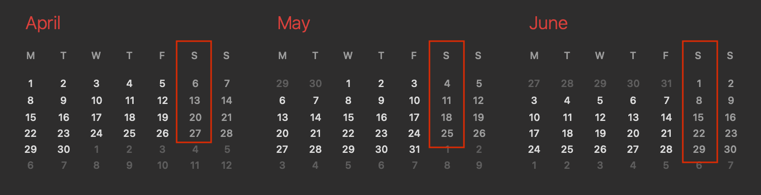

In [9]:
def get_data_parse_dt(weeks):
    '''
    Pass list of dates to retrieve weekly data from April, May, and June 2019. 
    Parse datetime from columns DATE and TIME.
    '''
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    weekly_data = []
    
    for week in weeks:
        file_url = url.format(week)
        weekly_data.append(pd.read_csv(file_url,
                               parse_dates=[['DATE','TIME']], 
                               keep_date_col=True))
    return pd.concat(weekly_data)

In [14]:
weeks = [190406, 190413, 190420, 190427,              # April
         190504, 190511, 190518, 190525,              # May
         190601, 190608, 190615, 190622, 190629]      # June
df = get_data_parse_dt(weeks)
df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2019-03-30 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576
2,2019-03-30 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622
3,2019-03-30 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710
4,2019-03-30 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2664248 entries, 0 to 205962
Data columns (total 12 columns):
 #   Column                                                                Dtype         
---  ------                                                                -----         
 0   DATE_TIME                                                             datetime64[ns]
 1   C/A                                                                   object        
 2   UNIT                                                                  object        
 3   SCP                                                                   object        
 4   STATION                                                               object        
 5   LINENAME                                                              object        
 6   DIVISION                                                              object        
 7   DATE                                                                  obj

In [18]:
df.describe()

,ENTRIES,EXITS
count,"2,664,248","2,664,248"
mean,"41,577,747","34,030,179"
std,"212,183,236","195,375,990"
min,0,0
25%,"335,306","135,765"
50%,"2,168,239","1,245,548"
75%,"6,774,170","4,601,610"
max,"2,129,395,010","2,124,195,831"


In [19]:
# df.nunique()
df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [20]:
# Strip whitespace from column names

df.columns = [column.strip() for column in df.columns]
df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [22]:
df['STATION'].nunique()

378

# 🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖

## 2. Select late night entry data

In [ ]:
late_night_mask = df.copy()

In [ ]:
# Mask selects the interval between 12:00 AM and 4:00 AM 
late_night_mask = (df['TIME'] == '04:00:00')
late_night_df = df[late_night_mask]
late_night_df.head(2)

In [ ]:
# Confirm df only has data from the 4:00 AM interval
late_night_df.TIME.unique()

## 3. Calculate late night entries

In [ ]:
late_night_entries_df = late_night_df.copy()
late_night_entries_df.head(2)

In [ ]:
# What type of data are in the DESC column? REGULAR and RECOVR AUD
# How many of the entries are RECOVR AUD? Can we filter them out? Yes, small percentage. 

late_night_entries_df.DESC.value_counts()

In [ ]:
# Mask selects the REGULAR entries in the DESC column

desc_mask = (late_night_entries_df['DESC'] == 'REGULAR')
late_night_entries_df = (late_night_entries_df[desc_mask])

In [ ]:
# Confirm that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique

(late_night_entries_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

In [ ]:
# Create new columns for the previous date and entries. 
# Apply a shift to calculate the previous day's entries. 

v = (late_night_entries_df[["DATE", "ENTRIES"]].apply(lambda grp: grp.shift(1)))
late_night_entries_df['PREV_DATE'] = v['DATE']
late_night_entries_df['PREV_ENTRIES'] = v['ENTRIES']

late_night_entries_df.head(2)

In [ ]:
# How many stations have a counter going in reverse? 

(late_night_entries_df[late_night_entries_df['ENTRIES'] < late_night_entries_df["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())


In [ ]:
# Adjust counter 

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter


In [ ]:
late_night_entries_df["LATE_NIGHT_ENTRIES"] = late_night_entries_df.apply(get_daily_counts, 
                                                                          axis=1, 
                                                                          max_counter=1000000)


In [ ]:
late_night_entries_df.head(2)

In [ ]:
# Drop row with the March 31, 2019 data, used it to calculate the previous entries, no longer neeeded. 

late_night_entries_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
late_night_entries_df.head(2)


In [ ]:
# Add up all turnstiles by station and reset index 

late_night_entries_df = (late_night_entries_df.groupby(['STATION', 'DATE_TIME', 'LINENAME'])
                         [['LATE_NIGHT_ENTRIES']]
                         .sum()).reset_index()
late_night_entries_df.info()

In [ ]:
# Add column DAY_OF_WEEK to display day of week (Monday = 0, Sunday = 6)

late_night_entries_df['DAY_OF_WEEK'] = pd.to_datetime(late_night_entries_df['DATE_TIME']).dt.dayofweek
late_night_entries_df.head(2)


## 4. Calculate rolling mean of late night entries

In [ ]:
rolling_mean_df = late_night_entries_df.copy()
rolling_mean_df.head(2)

In [ ]:
# Add column ROLLING_MEAN to capture the weekly rolling mean for each station 

rolling_mean_df['ROLLING_MEAN'] = (rolling_mean_df
                        .groupby('STATION')['LATE_NIGHT_ENTRIES']
                        .transform(lambda x: x.rolling(7,1).mean()))
rolling_mean_df[['STATION','DATE_TIME','LATE_NIGHT_ENTRIES','ROLLING_MEAN','DAY_OF_WEEK']].head(2) 
# rolling_mean_df

In [ ]:
# Mask selects the last day of each station's rolling mean; Sunday=6

last_rolling_day_mask = (rolling_mean_df['DAY_OF_WEEK'] == 6)
rolling_mean_df = rolling_mean_df[last_rolling_day_mask]
rolling_mean_df.head(2)

In [ ]:
# Comfirm df only has Sunday

rolling_mean_df.DAY_OF_WEEK.unique()


In [ ]:
# How many stations? 213; started with 378 
# Some stations were ommited during clean up. 
# Perhaps some stations don't have late night service or were closed for repair. 

len(rolling_mean_df.STATION.unique())


In [ ]:
# Sort by ROLLING_MEAN and reset index 

rolling_mean_df = rolling_mean_df.sort_values('ROLLING_MEAN', ascending=False).reset_index(drop=True)
rolling_mean_df.info()


In [ ]:
rolling_mean_group = (rolling_mean_df
                      .groupby('STATION')[['ROLLING_MEAN']].mean())

In [ ]:
rolling_mean_group.reset_index(inplace=True)

In [ ]:
# Select top stations with the highest rolling mean on Sunday

rolling_mean_group.sort_values('ROLLING_MEAN', ascending=False)
rolling_mean_group_top = rolling_mean_group.loc[:9]
rolling_mean_group_top

## 5. Plot top stations by highest late night rolling mean

### Which stations outside of Manhattan have high late night entries? 

In [ ]:
# Plot top stations: Rolling mean number of entres vs stations

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'STATION', y = 'ROLLING_MEAN', data = rolling_mean_group_top, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set(title='Top Stations: Rolling Mean Number of Entries vs. Stations')
ax.set(xlabel=('Station Name'))
ax.set(ylabel=('Rolling mean number of entries on last reporting day (Sunday)'))
plt.grid();


One station outside of Manhattan is both in Queens and on the 7 train. 
Let's look at the stations along the 7 line in Queens. 

## 6. Plot 7 train stations in Queens 

In [ ]:
seven_line_df = rolling_mean_df.copy() # Using df with rolling mean
seven_line_df.head(2)

In [ ]:
# Looking for linename of interest: 7 line 

seven_line_df = seven_line_df[seven_line_df['LINENAME'].str.contains('7', na=False)] 
seven_line_df.head(10)

# The 7 train shares stations with other train lines. Will omit multi-train stations in this analysis. 
# Line name as recorded in dataset: 7


In [ ]:
# Mask selects the 7 train only stations

seven_mask = (seven_line_df['LINENAME'] == '7')
seven_line_df = seven_line_df[seven_mask]
seven_line_df.head(2)

In [ ]:
# Comfirm df has only 7 line data

seven_line_df.LINENAME.unique()

In [ ]:
# How many 7 train stations in this dataset? 12

len(seven_line_df.STATION.unique())

In [ ]:
# How many stations in Queens? All but one, 34 ST-HUDSON YD.   

seven_line_df.STATION.unique()

In [ ]:
# Mask selects only the Queens stations

queens_mask = (seven_line_df['STATION'] != '34 ST-HUDSON YD')
seven_line_df = seven_line_df[queens_mask]
seven_line_df.head(5)

### Which 7 train stations in Queens have high late night entries? 

In [ ]:
# Plot 7 line in Queens: Rolling average late night entries vs Queens 7 train stations

plt.figure(figsize = (15,8))
ax = sns.barplot(x='STATION', y='ROLLING_MEAN', data=seven_line_df.sort_values('ROLLING_MEAN'), color='purple')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set(title='Queens 7 Train: Rolling Average Late Night Entries vs. Stations')
ax.set(xlabel=('Station Name'))
ax.set(ylabel=('Rolling average late night entries'))
plt.grid();


The range of people entering a station on the 7 train during late-night hours varies. 
One station has high late night entries.<br/>
What days are the busiest at Flushing Station? 



## 7. Plot average late night entries at Flushing Station by day of week

In [ ]:
flushing_df = late_night_entries_df.copy() # Using df without rolling mean

In [ ]:
# Mask selects FLUSHING-MAIN

flushing_mask = (flushing_df['STATION'] == 'FLUSHING-MAIN')
flushing_df = flushing_df[flushing_mask]


In [ ]:
# Confirm df only has Flushing data

flushing_df.STATION.unique()


In [ ]:
flushing_df.head(2)

In [ ]:
# Calculate Flushing WEEK_DAY_MEAN

flushing_df['WEEK_DAY_MEAN'] = (flushing_df
                                .groupby('DAY_OF_WEEK')['LATE_NIGHT_ENTRIES']
                                .transform(lambda x: x.mean()))
flushing_df.head(10)

In [ ]:
# Mask selects every day but Saturday=5. 
# Saturdays may record people going out late to bars or nightclubs

saturday_mask = (flushing_df['DAY_OF_WEEK'] != 5)
flushing_df = flushing_df[saturday_mask]
flushing_df.head(5)

### What days are the busiest at Flushing Station?

In [ ]:
# Plot Flushing average week: Average late night entries vs day of week

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'DAY_OF_WEEK', y = 'WEEK_DAY_MEAN', data = flushing_df, color='brown')
ax.set(title='Flushing Station: Average Late Night Entries vs. Day of Week')
ax.set(xlabel=('Day of week (Saturday omitted)'))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sun'])
ax.set(ylabel=('Average late night entries'))
plt.grid();


Tuesday through Friday have the highest late night entries at the Flushing station.